<a href="https://colab.research.google.com/github/jakejeong5007/VizWiz/blob/main/VizWiz1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://vizwiz.org/wp-content/uploads/2019/05/logo-name1.png)

This week, we'll be delving right into the projects. We're going to build an AI tool that can help the visually impaired navigate the world. In this project, we will:
* Explore our dataset and understand our problem
* Build different Language Model variants to solve our problem
* Carry on an error analysis to understand our model performance and think about ways to improve it.

We'll start by understanding our problem, identifying:
* Who are our key stakeholders? 
* What do they want to solve? 
* What kind of data do they have? 

Once we have all of this information, we will take a step back and plan our approach to designing our VQA system.


In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }


### preparing definitions
# downloading and loading data
import gdown

# file variables
metadata_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/Annotations.zip'
metadata_path        = './metadata.zip'

###
gdown.download(metadata_url, './metadata.zip', True)
!unzip ./metadata.zip

# file variables
data_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/small.h5'
image_data_path      = 'small.h5'

###
gdown.download(data_url, 'small.h5', True)

import json
import random

def get_annotations(annotations_path):
    with open(annotations_path, 'r') as f:
      metadata = json.load(f)
    return metadata

def get_random_annotation(annotations_path):
    with open(annotations_path, 'r') as f:
      metadata = json.load(f)
    i = random.choice(range(len(metadata)))
    return metadata[i]

# getting data
annotations_path = './Annotations/val.json'
vocab_path = 'vocab.json'

def get_questions(annotations_path):
  
  with open(annotations_path, 'r') as f:
    annos = json.load(f)

  questions = set()
  for i in range(len(annos)):
    if annos[i]['answerable'] == 0:
      continue
    question = annos[i]['question']
    questions.add(question)

  return questions
  
from collections import Counter 
  
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 

def get_answers(annotations_path):
  with open(annotations_path, 'r') as f:
    annos = json.load(f)
  answers = set()
  for i in range(len(annos)):
    if annos[i]['answerable'] == 0:
      continue
    ans = annos[i]['answers']
    answers_list = []
    for a in ans:
      answers_list += [a['answer']]
    answers.add(most_frequent(answers_list))
  return answers

def get_image_paths(annotations_path):
  with open(annotations_path, 'r') as f:
    annos = json.load(f)

  images = set()
  for i in range(len(annos)):
    if annos[i]['answerable'] == 0:
      continue
    image = annos[i]['image']
    images.add(image)

  return images

def parse_vocab(q, a):
  vocab = set()
  for qu in q:
    if '?' in qu:
      qu = qu.replace('?', '')

    vocab |= set(qu.split(' '))
  return vocab

## data and ploting
import h5py
import matplotlib.pyplot as plt

def get_data(path):
    data = h5py.File(path, 'r')
    images = data['images']
    image_idx = data['image_indices']
    questions = data['questions_str']
    answers = data['answers_str']
    return images, image_idx, questions, answers

def plot_image(img, questions=None, answers=None, indices=None):
    if indices is None:
      plt.imshow(img/255)
      plt.show()
    else:
      for i in indices:
        print('Question: ', questions[i])
        print('Answer: ', answers[i])
        plt.imshow(img[i]/255)
        plt.show()


Archive:  ./metadata.zip
   creating: Annotations/
  inflating: Annotations/val.json    
  inflating: Annotations/train.json  
  inflating: Annotations/test.json   


# Milestone 1. Understanding VizWiz data


In [ ]:
#@title Who is considered blind? Visually impaired? { display-mode: "form" }
Blindness = "the state of being unable to see due to injury, disease or genetic condition." #@param ["a decrease in the ability to see to a certain degree that causes problems not fixable by usual means, such as glasses.","the state of being unable to see due to injury, disease or genetic condition.", "Fill Me In"]
Visual_Impairment = "a decrease in the ability to see to a certain degree that causes problems not fixable by usual means, such as glasses." #@param ["a decrease in the ability to see to a certain degree that causes problems not fixable by usual means, such as glasses.","the state of being unable to see due to injury, disease or genetic condition.", "Fill Me In"]

if Blindness == "The state of being unable to see due to injury, disease or genetic condition.":
  print('Indeed! It is %s.'%Blindness)
else:
  print('Are you sure about this?')
  
if Visual_Impairment == "a decrease in the ability to see to a certain degree that causes problems not fixable by usual means, such as glasses.":
  print("Right! It is %s.")
else:
  print('Are you sure about this?')


Are you sure about this?
Right! It is %s.


## **Discussion:** Try to answer the questions corresponding to the images.

**What color is this object?**

<img src=https://zdnet4.cbsistatic.com/hub/i/2020/06/09/2eacd230-d144-4224-9e64-aa012e900877/coca-cola-coke-coca-cola.jpg width="400">

---



In [ ]:
#@title Discussion: Is this question answerable? If yes, can you guess the right answer? { display-mode: "form" }

print('Yes! It is answerable.')
print("And right! This is a red soda can.")

Yes! It is answerable.
And right! This is a red soda can.


**Does this place sell pepsi?**

<img src=https://www.realityblurred.com/realitytv/images/2016/06/blurred-soda-bottles.jpg width="400">

---



In [ ]:
#@title Is this question answerable? If yes, can you guess the right answer? { display-mode: "form" }
print('Indeed! It is not answerable.')


Indeed! It is not answerable.


## **Discussion:** Say we have a tool that can answer these types of questions.
Can visually impaired people benefit from such technology?


In [ ]:
#@title What do we need to develop and use such a tool? { display-mode: "form" }

Hardware = "Smartphone" #@param ["Camera","Smartphone","Laptop","Fill Me In"]
Data = "Images+Questions+Answers" #@param ["Images","Images+Questions","Images+Questions+Answers","Fill Me In"]
Data_collectors = "Visually impaired people" #@param ["Fill Me In", "Visually impaired people", "Sighted people"]

if (Hardware == "Smartphone") & (Data == "Images+Questions+Answers"):
  print("We only need a smart phone with camera and Visual Question Answering dataset to make this possible. \n The user only needs to take a picture with their smartphone and ask a question. \n The AI in our smartphone can figure out ways to answer the question and assist the user.") # embelish this explanation!!!
else:
  print('Try again! Think about a simple way to use such a tool.')

if Data_collectors == "Visually impaired people":
  print("Correct! Since they will be using such a tool, the data must come from them.")
else:
  print('Try again! Think about who will be using such a tool.')




We only need a smart phone with camera and Visual Question Answering dataset to make this possible. 
 The user only needs to take a picture with their smartphone and ask a question. 
 The AI in our smartphone can figure out ways to answer the question and assist the user.
Correct! Since they will be using such a tool, the data must come from them.


## While most people have a smartphone, collecting such a data to design a tool for navigation is challenging. **VizWiz-VQA** represents a solution!


# Milestone 2. Understand and visualizing our data

## What is **VizWiz-VQA**?

VizWiz-VQA is an artificial intelligence challenge to design algorithms that answer visual questions asked by people who are blind. 
The dataset was collected by blind people who each took an image and recorded a spoken question about it, together with 10 crowdsourced answers per visual question. The aim of this work is to educate people about the technological needs of blind people while providing an opportunity for researchers to develop assistive technologies that eliminate accessibility barriers for blind people.




## Activity 2a. What data do we have?


### Exercise (Coding)

We use the `get_random_annotation(annotations_path)` function to show the format of a visual question.

In [ ]:
### YOUR CODE HERE
get_random_annotation(annotations_path)
### END CODE

{'answer_type': 'other',
 'answerable': 1,
 'answers': [{'answer': 'beans', 'answer_confidence': 'yes'},
  {'answer': 'pinto beans', 'answer_confidence': 'yes'},
  {'answer': 'pinto beans', 'answer_confidence': 'yes'},
  {'answer': 'beans', 'answer_confidence': 'yes'},
  {'answer': 'beans', 'answer_confidence': 'yes'},
  {'answer': 'pinto beans', 'answer_confidence': 'yes'},
  {'answer': 'beans', 'answer_confidence': 'yes'},
  {'answer': 'pinto beans', 'answer_confidence': 'yes'},
  {'answer': 'pinto beans', 'answer_confidence': 'yes'},
  {'answer': 'pento beans', 'answer_confidence': 'yes'}],
 'image': 'VizWiz_val_00002370.jpg',
 'question': 'May I know what is in this can please?'}

We are provided with a set of image-question pairs. Details about each visual question are included above. 

**Discussion:** We see a few keys in our dict like `image`, `answerable`, `question`, `answers`.

What do they represent?

## Dataset statistics

We explore VizWiz in order to have more insight on our data.
Our dataset is split into 3 different sets: **Train, Validation and Test**. **What is the role of each dataset?**

**Train Set:** Our training set is like a training manual. Our algorithm will read, or 'train', on this over and over again to try and learn its task. 

**Validation Set:** Our test set is like a test. It is testing our model on problems that it has not seen before. 

**Test Set:** This is our field data. We are only provided with image-question pairs without answers. VizWiz is a challenge proposed to the AI community. In order to evaluate the models proposed by ML practitioners, a dataset is provided online without the labels ensuring a fair evaluation by the organizers of the challenge.

**We usually have a much larger train set than our validartion and test sets. Let's see if this is the case with our data!**


#### Train stats (`exercise`): 
we would like to find out the size of our dataset. In order to do so, we provide you with a few functions:
1. `get_questions(annotations_path)`: extracts the set of unique questions in the dataset.
2. `get_answers(annotations_path)`: extracts the set of unique answers.
3. `get_image_paths(annotations_path)`: extracts the set of unqie images.

`annotations_path`: the specified annotations file (`train_annos_path`, `val_annos_path`, `test_annos_path`)

We would like to use the provided functions to get insight on our train data.

**Make sure to print the results!**

In [ ]:
### YOUR CODE HERE
train_annos_path = './Annotations/train.json'
train_questions = get_questions(train_annos_path)
train_answers = get_answers(train_annos_path)
train_images = get_image_paths(train_annos_path)
print(len(train_questions))
print(len(train_answers))
print(len(train_images))
print()

val_annos_path = './Annotations/val.json'
val_questions = get_questions(val_annos_path)
val_answers = get_answers(val_annos_path)
val_images = get_image_paths(val_annos_path)
print(len(val_questions))
print(len(val_answers))
print(len(val_images))
print()

#test_annos_path = './Annotations/test.json'
#test_questions = get_questions(test_annos_path)
#test_answers = get_answers(test_annos_path)
#test_images = get_image_paths(test_annos_path)
#print(len(test_questions))
#print(len(test_answers))
#print(len(test_images))
### END CODE

7259
5621
14991

1802
1523
2934



#### Validation stats:

In [ ]:
### YOUR CODE HERE

### END CODE

Make sure to get the statistics for the test set if interested!

## Activity 2b. What does our data look like? 

We need to understand: what represents a data point in our dataset? Is it numeric? Is it categorical? Is it a vector or a matrix?

**Question: What do you think the data is?** 

Discuss this with your group!



### Exercise (Coding)

We will check what we think the data is against what python tells us it is. 

We'll start by loading a subset of our data using `get_data`. 


`get_data` is a function that **loads** our images and visual questions

```
images, image_indices, questions, answers = get_data(path)
```

Make sure to print our data and figure out what each variable represents.

You can use the `.shape` function or just print function to explore the data.

**Let's try loading our data!**

In [ ]:
path = 'small.h5'
### YOUR CODE HERE
images, image_indices, questions, answers = get_data(path)
### END CODE

**Explore our data here**

In [ ]:
print(images.shape)
img_idx = image_indices[0]
images[img_idx]
print(questions[0])
print(answers[0])

(50, 224, 224, 3)
b'Can you tell me what this medicine is please?'
b'night time'


`images` is a numpy array of our images, with size `(number of images, 224, 224, 3)`. 

`image_indices` is a numpy array of our images indices for each q-a pair, with size `(number of q-a pairs,)`.

`questions` is a list of questions, with size `(number of q-a pairs, )`.

`answers` is a list of answers, with size `(number of q-a pairs, )`. 

**What kind of data do we have? What are our inputs? What are our outputs?**

**Visualize single data points with plot_image**

Let's see a single data point. 

`plot_image` can take in either one image or many images. To use it with one image that is 3D, call:

```
plot_image(image)
```

To use it with many images, call:


```
plot_image(images, questions, answers, indices)
```

where:
* `images`: all of our images in one array
* `questions`: the questions corresponding to the images
* `answers`: the answers corresponding to the image-question pairs
* `indices`: which images we want to see

**Plot a single image:**

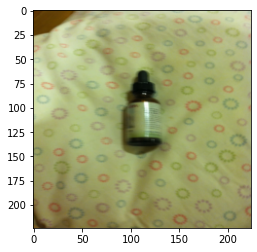

In [ ]:
# plot a SINGLE image
### YOUR CODE HERE
img_idx = image_indices[10]
image = images[img_idx]
plot_image(image)
### END CODE

Let's plot more images. Make sure to specify a list of indices, we would like to tke a look at.

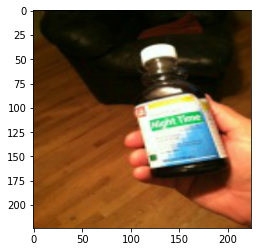

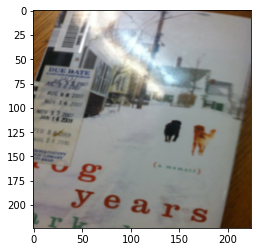

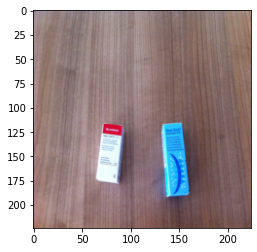

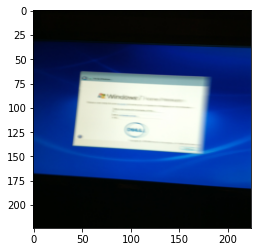

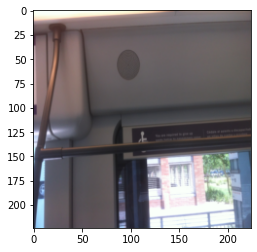

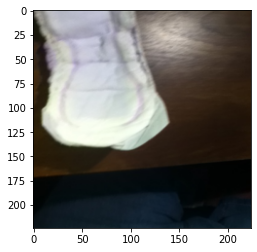

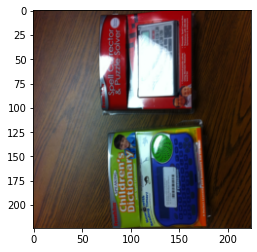

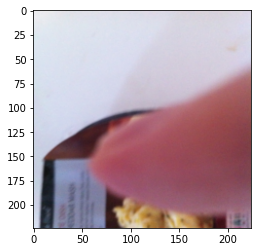

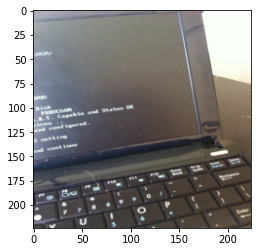

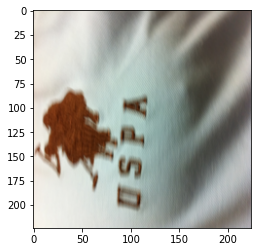

Question:  b'Can you tell me what this medicine is please?'
Answer:  b'night time'


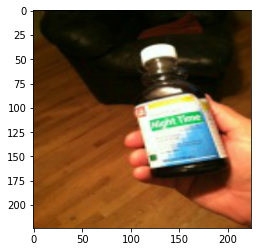

Question:  b'What is the title of this book? '
Answer:  b'dog years'


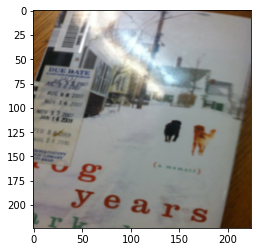

Question:  b'Which one is the blue one?'
Answer:  b'right'


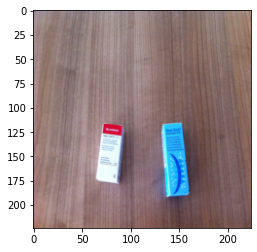

In [ ]:
### YOUR CODE HERE
# specify indices
indices = [0, 1, 2]
# plot images
for i in range(10):
  img_idx = image_indices[i]
  image = images[img_idx]
  plot_image(image)

plot_image(images, questions, answers, indices)
### END CODE


# Milestone 3. Preparing our data



## Activity 3a. Defining our machine learning problem

Before we build our model, we have to identify what kind of problem it will solve and what data it's going to use. 

### Exercise (Discussion) 

What WILL our model look like? Remember, in machine learning, we always identify the nature of our task, the type of our **inputs** and **outputs**. Our goal is to predict **outputs** from **inputs**.

Since the problem involves natural language, it is an NLP problem. 

In [ ]:
#@title How will our model operate? { display-mode: "form" }

#@markdown What are our inputs? 
inputs = "images+questions" #@param ["images+questions", "images", "image edges", "answers", "FillMe"]

#@markdown What are our outputs? 
outputs = "answers" #@param ["images+questions", "images", "image edges", "answers", "FillMe"]

#@markdown What kind of format are our questions? 
q_type  = "array of integers" #@param ["numerical values", "text", "array of integers", "FillMe"]

#@markdown What kind of format are our answers? 
a_type  = "numerical values" #@param ["numerical values", "text", "array of integers", "FillMe"]

#@markdown What kind of problem will our AI model solve? 
problem_type  = "classification" #@param ["classification", "regression","FillMe"]


if inputs == "images+questions":
  print("Yes, our inputs are our image-question pairs!")
else:
  print('Not quite our inputs.')

if outputs == "answers":
  print("Yes, our outputs are answers!")
else:
  print('Not quite our outputs.')

if q_type == "array of integers":
  print("Yes, the questions will be in the format of an array of integers.")
else:
  print("Not quite our question type.")

if a_type == "numerical values":
  print("Yes, our answer will be numerical values.")
else:
  print("Not quite our answer type.")
  
if problem_type == "classification":
  print("We are trying to predict labels, therefore this is classification!")
else:
  print('Not quite our problem!')

Yes, our inputs are our image-question pairs!
Yes, our outputs are answers!
Yes, the questions will be in the format of an array of integers.
Yes, our answer will be numerical values.
We are trying to predict labels, therefore this is classification!


## Activity 3b. Building our vocab

As we said in the previous exercise, our questions and answers will not be in the text format. Indeed, in NLP, each word in our text needs to be mapped to a numerical value, also known as a **token**. In order to do so, we build what is called a vocabulary. We will use our vocab for processing our text and mapping our inputs to arrays of integers.

### Exercise (Coding)


In order to build our vocab, we need to get a list of all the words we have in our dataset. We do so by collecting all our questions and answers. Then, we use the following function to build our vocab:

`build_vocab(q, a, threshold)`

where `q` is the set of all questions, `a` is the set of all answers and `threshold` represents the minimum number of occurences in order to keep a word in our vocab. 

Remember that we can get our set of all questions and set of all answers, using the `get_questions(annotations_path)` and `get_answers(annotations_path)`.

In [ ]:
#@title Run this to prepare our functions! { display-mode: "form" }

#cite Ranjay's IQ paper for code
import nltk
import re
import numpy as np
nltk.download('punkt')

class Vocabulary(object):

    def __init__(self):
        """Constructor for Vocabulary.
        """
        # Init mappings between words and ids
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.add_word('<pad>')
        self.add_word('<start>')
        self.add_word('<end>')
        self.add_word('<unk>')

    def add_word(self, word):
        if word not in self.word2idx:
          self.word2idx[word] = self.idx
          self.idx2word[self.idx] = word
          self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

    def save_vocab(self, location):
        with open(location, 'w') as f:
            json.dump({'word2idx': self.word2idx,
                       'idx2word': self.idx2word,
                       'idx': self.idx}, f)

    def load_vocab(self, location):
        with open(location, 'r') as f:
            data = json.load(f)
            self.word2idx = data['word2idx']
            self.idx2word = data['idx2word']
            self.idx = data['idx']

    def decode_sentence(self, tokens):
        words = []
        for token in tokens:
            word = self.idx2word[str(token)]
            if word == '<end>':
                break
            if word not in ['<pad>', '<start>', 
                            '<end>', '<unk>']:
                words.append(word)
        return ' '.join(words)

def build_vocab(q, a, threshold, vocab_path='vocab.json'):
    """Build a simple vocabulary wrapper.
    """
    print("Tokenizing questions...")
    num_questions = 0
    counter = Counter()
    for qa in q:
        tokens = nltk.tokenize.word_tokenize(qa.lower())
        counter.update(tokens)
            
    print("Tokenizing answers...")
    num_answers = 0
    for ans in a:
        tokens = nltk.tokenize.word_tokenize(ans.lower())
        counter.update(tokens)

    # If a word frequency is less than 'threshold', then the word is discarded.
    print("Building vocab...")
    words = []
    for word, count in counter.items():
      if count < threshold:
        continue
      words += [word]

    # Adds the words to the vocabulary.
    vocab = Vocabulary()
    for i, word in enumerate(words):
        vocab.add_word(word)
    print("Our vocab is ready. We have tokenized %d words."%len(vocab))
    vocab.save_vocab(vocab_path)
    print("Our vocab is saved as %s."%vocab_path)
    return vocab

def tokenize(sentence):
    """Tokenizes a sentence into words.
    Args:
        sentence: A string of words.
    Returns:
        A list of words.
    """
    #sentence = str(sentence)
    if len(sentence) == 0:
        return []
    sentence = re.sub('\.+', r'.', sentence)
    sentence = re.sub('([a-z])([.,!?()])', r'\1 \2 ', sentence)
    sentence = re.sub('\s+', ' ', sentence)

    tokens = nltk.tokenize.word_tokenize(
            sentence.strip().lower())
    return tokens

### Here we load the train and test data for your to use.

class TextProcessing(object):
    """Helps process all text into tokens.
    """

    def process_text(self, text, vocab, max_length=None):
        tokens = tokenize(text)
        output = []
        output.append(vocab('<start>')) # <start>
        output.extend([vocab(token) for token in tokens])
        output.append(vocab('<end>')) # <end>
        length = min(len(tokens) + 2, max_length)
        if length == max_length:
            output[max_length - 1] = vocab('<end>')
        if max_length is not None:
            # Adding padding to make sure that the length is correct.
            while len(output) < max_length:
                output.append(vocab('<pad>'))
            # Ensure that the output is of max_length.
            output = output[:max_length]
        return np.array(output), length

def preprocess_text(annotations_path, vocab_path):
  with open(annotations_path, 'r') as f:
    annotations = json.load(f)
  
  processor = TextProcessing()
  vocab = Vocabulary()
  vocab.load_vocab(vocab_path)
  questions, answers = [], []
  for entry in annotations:
      #get answer
      if entry['answerable'] == 1:
          answers_list = []
          for a in entry['answers']:
              answers_list += [a['answer']]
          ans = most_frequent(answers_list)

          tokenized_questions, _ = processor.process_text(
          entry['question'], vocab, max_length=20)
          questions.append((entry['question'], tokenized_questions))

          tokenized_answers, _ = processor.process_text(
          ans, vocab, max_length=10)
          answers.append((ans, tokenized_answers))

  return questions, answers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
### YOUR CODE HERE
q = get_questions(annotations_path)
a = get_answers(annotations_path)
vocab = build_vocab(q, a, 2)
### END CODE

Tokenizing questions...
Tokenizing answers...
Building vocab...
Our vocab is ready. We have tokenized 1128 words.
Our vocab is saved as vocab.json.


We can use the `load_vocab(vocab_path)` to load our vocab.

Let's play with our vocab! Choose a word and see what token is assigned to the chosen word.

In [ ]:
#@title Choose a word or a number and get the corresponding mapping

word = "object" #@param {type:"string"}
number = "58" #@param {type:"string"}

if word is not None:
  if word in vocab.word2idx:
    print('The word \"%s\" maps to token \"%s\".'%(word, vocab.word2idx[word]))
  else:
    print('This word is not in our vocab.')

if number is not None:
  if int(number) in vocab.idx2word.keys():
    print('Token number \"%d\" maps to the following word: \"%s\".'%(int(number), vocab.idx2word[int(number)]))
  else:
    print('This token number is not in our vocab.')

The word "object" maps to token "152".
Token number "58" maps to the following word: "window".


### Challenge exercise (Coding)
Decoding and encoding sentence. Let's code up two functions that help you encode and decode our sentences. 

We use `vocab.idx2word[str(token)]` to transform tokens into words

and `vocab.word2idx[word]` to transform words into tokens.

In [ ]:
def decode(tokens, vocab):
    words = []
    ### YOUR CODE HERE
    for i in range(len(tokens)):
      words.append(vocab.idx2word[str(tokens[i])])
    ### END CODE
    return ' '.join(words)

def encode(sentence, vocab):
    sentence_list = sentence.split()
    tokens = []
    ### YOUR CODE HERE
    for i in range(len(sentence_list)):
      tokens.append(vocab.word2idx[sentence_list[i]])
    ### END CODE
    return ' '.join(tokens)

## Activity 3c. Preprocessing our text

With our vocab ready, we can preprocess our questions and answers.

In order to do so, we use the following function:

```tokenized_questions, tokenized_answers = preprocess_text(annotations_path)```




In [ ]:
### YOUR CODE HERE
vocab_path = 'vocab.json'
tokenized_questions, tokenized_answers = preprocess_text(annotations_path, vocab_path)
### END CODE

In [ ]:
#@title Choose an index

index = "0" #@param {type:"string"}

if int(index) < len(questions):
  print("Our original text is: \n Question: %s \n Answer: %s"%(questions[int(index)][0], answers[int(index)][0]))
  print("Our encoded text is: \n Question: %s, \n Answer: %s"%(questions[int(index)][1], answers[int(index)][1]))
else:
  print("Choose an index less than %d"%len(questions))

Our original text is: 
 Question: 67 
 Answer: 110
Our encoded text is: 
 Question: 97, 
 Answer: 105


# Fin! Our data is now ready! We can start working on our model!


![](https://vizwiz.org/wp-content/uploads/2019/05/logo-name1.png)